In [26]:
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import math
import numpy as np
import pandas as pd
import re

from ast import literal_eval
from itertools import product
from matplotlib.transforms import ScaledTranslation
from matplotlib.ticker import NullFormatter
from os import makedirs
from os.path import isdir, isfile
from pathlib import Path
from string import ascii_lowercase
from time import time
from tqdm import tqdm
from constants import *
from UTILS.mutils import njoin, str2bool, str2ls, create_model_dir, convert_train_history
from UTILS.mutils import collect_model_dirs, find_subdirs, load_model_files
from UTILS.figure_utils import matrixify_axs, label_axs
from plot_results import get_metric_curves, load_seed_runs, final_epoch_stats
DSEP = njoin('a', 'b')[1]

# Phase ensembles

In [27]:
def phase_ensembles(models_root, selected_dataset='cifar10',
                    fns_manifold='rd', qk_share=True, selected_alphas='1,2',
                    metrics='val_acc,val_loss',
                    is_ops = [True],  # [False,True]
                    cbar_separate=False, display=False):

    global qk_shares

    assert fns_manifold in ['sp', 'rd', 'v2_rd'], f'{fns_manifold} does not exist!'
    qk_share, cbar_separate, display = map(str2bool, (qk_share, cbar_separate, display))
    metrics, is_ops = str2ls(metrics), str2ls(is_ops)

    # collect subdirs containing the model directories
    model_root_dirs = models_roots = find_subdirs(njoin(models_root), MODEL_SUFFIX)
    print(model_root_dirs)                  

    # all trained model types
    model_types = []   
    DCT_ALL = {} 
    for model_root_dir in model_root_dirs:
        DCT_cur = collect_model_dirs(model_root_dir, suffix=MODEL_SUFFIX)
        for model_type, df_model_cur in DCT_cur.items():
            df_clean = df_model_cur.dropna(subset='alpha') if 'alpha' in df_model_cur.columns else df_model_cur
            if model_type not in DCT_ALL:
                model_types.append(model_type)
                DCT_ALL[model_type] = df_clean
            else:
                DCT_ALL[model_type] = pd.concat([DCT_ALL[model_type], df_clean], ignore_index=True)                    

    # isolate partiulcar setting for qk_share
    df_model = DCT_ALL[[model_type for model_type in list(DCT_ALL.keys()) if fns_manifold in model_type][0]]
    df_model.reset_index(drop=True, inplace=True)
    qk_shares = list(df_model.loc[:,'qk_share'].unique())
    assert qk_share in qk_shares, f'qk_share = {qk_share} setting does not exist!'
    
    # print('df_model')
    # print(df_model)

    # ---- col names ----
    stats_colnames = ['min', 'max', 'mid', 'median', 'mean', 'std', 'counter']   

    # ----- general settings -----
    num_attention_heads, num_hidden_layers, hidden_size =\
         DCT_ALL[list(DCT_ALL.keys())[0]].loc[0,['num_attention_heads', 'num_hidden_layers', 'hidden_size']]
    #dataset = DCT_ALL[list(DCT_ALL.keys())[0]].loc[0,'dataset_name']
    assert selected_dataset in DCT_ALL[list(DCT_ALL.keys())[0]].loc[:,'dataset_name'].unique(), 'selected_dataset does not exist'

    # ----- fns setting -----
    alphas = sorted(df_model.loc[:,'alpha'].unique())[::-1]  # large to small
    epss = sorted(df_model.loc[:,'bandwidth'].unique())    
    if selected_alphas.lower() == 'none':
        selected_alphas = alphas
    else:
        selected_alphas = [float(selected_alpha) for selected_alpha in str2ls(selected_alphas)]
    #eps = epss[0]
    eps = 1  # hard coded

    # ----- models to plot -----
    fns_model_type = fns_manifold + 'fns' + MODEL_SUFFIX    
    other_model_types = ['dp' + MODEL_SUFFIX]  # 'sink' + MODEL_SUFFIX
    model_types_to_plot = [fns_model_type] + other_model_types
            
    print(f'model_types_to_plot: {model_types_to_plot}')

    nrows, ncols = len(metrics), len(is_ops)     
    # figsize = (3*ncols,3.5*nrows)
    fig, axs = plt.subplots(nrows,ncols,figsize=(5,4))
    # axs = matrixify_axs(axs, nrows, ncols)  # convert axs to 2D array
    # label_axs(fig, axs)  # alphabetically label subfigures             

    model_types_plotted = []
    model_types_seeds = {}     
    for (row_idx, metric), (col_idx, is_op) in product(enumerate(metrics), enumerate(is_ops)):
        ax = axs[row_idx, col_idx] 
        # summary statistics
        row_stats = []

        print(f'model_type = {model_type}')        
        for model_type in model_types_to_plot:
            if is_op:
                model_type = 'op' + model_type
            if model_type in DCT_ALL.keys():
                df_model = DCT_ALL[model_type]
            else:
                continue
            # matching conditions for model setup
            condition0 = (df_model['ensembles']>0)&(df_model['qk_share']==qk_share)&(df_model['is_op']==is_op)&\
                         (df_model['model_dir'].str.contains(selected_dataset))&\
                         (df_model['model_dir'].str.contains(f'{model_type}-'))   
            matching_df = df_model[condition0]

            if model_type not in model_types_plotted:
                model_types_plotted.append(model_type)

            lstyle_model = LINESTYLE_DICT[model_type]
            for alpha in selected_alphas:
                is_fns = 'fns' in model_type
                alpha = alpha if is_fns else None
                matching_df.reset_index(drop=True, inplace=True)                                  

                # color
                if is_fns:
                    color = '#2E63A6' if alpha == 1.2 else '#A4292F'
                else:
                    # color = 'k'
                    color = '#636363'
                # color = HYP_CMAP(HYP_CNORM(alpha)) if is_fns else OTHER_COLORS_DICT[model_type]  
                # -------------------- SINK, DP -------------------- 
                model_info = matching_df 
                # -------------------- FNS --------------------
                if is_fns:
                    # matching conditions for FNS setup
                    condition = (matching_df['alpha']==alpha) & (matching_df['bandwidth']==eps)
                    model_info = model_info[condition]
                # get aggregated training curves
                if model_info.shape[0] > 0:
                    seeds, qk_share = (model_info[k].item() for k in ('seeds', 'qk_share'))                
                    epochs, run_perf_all = load_seed_runs(model_info['model_dir'].item(), seeds, metric)   
                else:
                    continue

                if run_perf_all is not None:
                    counter = run_perf_all.shape[1]
                    metric_curves = get_metric_curves(run_perf_all)      
                    exe_plot = ax.plot(epochs, metric_curves[1], linestyle='-', c=color, alpha=1, clip_on=False, label='DP' if not is_fns else rf'$\alpha = {alpha}$')
                    if (row_idx,col_idx) == (0,0):
                        im = exe_plot                      
                    # Calculate std                       
                    metric_std = np.nanstd(run_perf_all.to_numpy(), axis=1)
                    ax.fill_between(epochs, metric_curves[1]-metric_std, metric_curves[1]+metric_std, color=color, alpha=0.3, clip_on=False, edgecolor='none') 

                    # results of the final epoch
                    row_stats.append([model_type, alpha] +\
                                     final_epoch_stats(run_perf_all,metric) + [counter])    
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.set_xlim([0,125])
                    ax.set_xticks([0] + list(range(25,126,25)))
                if not is_fns:
                    break  # only do once if model is not FNS type

        summary_stats = pd.DataFrame(data=row_stats, columns=['model_type','alpha']+stats_colnames)

        # print message
        print(metric)
        print(f'is_op = {is_op}, qk_share = {qk_share}')
        print(summary_stats)
        print('\n')                    

    for cidx in range(ncols):
        axs[0,cidx].set_ylim(31,80)
        axs[0,cidx].margins(0)
        #ax.set_yticks([70,75,80])
        axs[1,cidx].set_ylim([0.6,2.1])
        axs[1,cidx].set_yticks([1, 1.5, 2])
        axs[1,cidx].margins(0)

    # # labels
    # model_labels = []
    # for model_type in model_types_plotted:  
    #     if model_type[:2] != 'op': 
    #         color = 'k' if 'fns' in model_type else OTHER_COLORS_DICT[model_type]            
    #         model_label = NAMES_DICT[model_type]
    #         if model_label not in model_labels:            
    #             axs[0,0].plot([], [], c=color, linestyle=LINESTYLE_DICT[model_type], label=model_label)
    #             model_labels.append(model_label)

    # # legend
    axs[0,0].legend(loc='best', frameon=False)                     
    # for alpha in selected_alphas[::-1]:
    #     axs[0,0].plot([], [], c=HYP_CMAP(HYP_CNORM(alpha)), linestyle='solid', 
    #                   label=rf'$\alpha$ = {alpha}')         
    # ncol_legend = 2  #if len(model_types_plotted) == 3 else 1
    # if len(model_types_plotted) >= 2:
    #     #axs[0,0].legend(loc='best', ncol=ncol_legend, frameon=False)           
    #     axs[0,0].legend(loc='best', ncol=ncol_legend, frameon=False)                     

    # Add shared x and y labels     
    #fig.supxlabel('Epochs', fontsize='medium'); fig.supylabel(NAMES_DICT[metrics[0]], fontsize='medium')

    for row_idx in range(len(qk_shares)):        
        for col_idx, is_op in enumerate(is_ops):  
            ax = axs[row_idx, col_idx]
            #ax.set_ylabel(NAMES_DICT[metric])
            if row_idx == 0:
                #ax.set_title(NAMES_DICT[metric])
                ax_title = r'$W \in O(d)$' if is_ops[col_idx] else r'$W \notin O(d)$'
                ax.set_title(ax_title)
            
            axs[row_idx,col_idx].sharey(axs[row_idx, 0])
            axs[-1,col_idx].set_xlabel('Epochs')
        # axs[row_idx,0].set_ylabel(NAMES_DICT[metrics[row_idx]])
    axs[0,0].set_ylabel('Testing accuracy (%)')
    axs[1,0].set_ylabel('Testing loss')

    # Adjust layout
    plt.subplots_adjust(wspace=0.4, hspace=0.3)            

    dataset_name_short = ''
    if isinstance(selected_dataset,str):
        if '_' in selected_dataset:
            for s in selected_dataset.split('_'):
                dataset_name_short += s[0]
        else:
            dataset_name_short += selected_dataset

    model_types_short = [model_type.replace(MODEL_SUFFIX,'') for model_type in model_types_plotted]
    
    return fig, axs

['q:\\scratch\\uu69\\cq5024\\projects\\fractional-attn\\vit-pytorch\\.droot\\full_models\\4L-ps=4-preln\\config_qkv\\cifar10\\layers=4-heads=6-hidden=48-qkv']


q:\scratch\uu69\cq5024\projects\fractional-attn\vit-pytorch\UTILS\mutils.py:216: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)
q:\scratch\uu69\cq5024\projects\fractional-attn\vit-pytorch\UTILS\mutils.py:216: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


model_types_to_plot: ['rdfnsvit', 'dpvit']
model_type = rdfnsvit
val_acc
is_op = False, qk_share = False
  model_type  alpha        min        max        mid     median       mean  \
0   rdfnsvit    1.2  76.005185  76.005185  76.005185  76.005185  76.005185   
1   rdfnsvit    2.0  74.791002  74.791002  74.791002  74.791002  74.791002   
2      dpvit    NaN  75.955427  75.955427  75.955427  75.955427  75.955427   

   std  counter  
0  NaN        1  
1  NaN        1  
2  NaN        1  


model_type = dpvit
val_acc
is_op = True, qk_share = False
   model_type  alpha        min        max        mid     median       mean  \
0  oprdfnsvit    1.2  76.602292  76.602292  76.602292  76.602292  76.602292   
1  oprdfnsvit    2.0  75.467747  75.467747  75.467747  75.467747  75.467747   
2     opdpvit    NaN  75.547385  75.547385  75.547385  75.547385  75.547385   

   std  counter  
0  NaN        1  
1  NaN        1  
2  NaN        1  


model_type = opdpvit
val_loss
is_op = False, qk_share = Fal

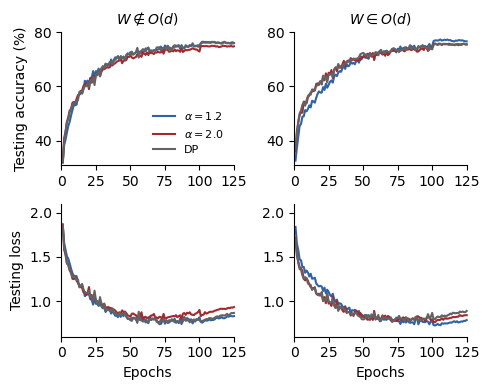

In [28]:
%matplotlib inline
from constants import FIGS_DIR
fig, axs = phase_ensembles(njoin(DROOT, 'full_models', '4L-ps=4-preln'), is_ops=[False,True], selected_alphas='1.2,2', qk_share=False)
plt.tight_layout()
SAVE_DIR = njoin(FIGS_DIR, 'vit-task')    
fig_file = 'phase_ensembles'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()